En este codigo ya se realizan las transformaciones con foco en el sistema de recomendacion.

Se realiza lo siguiente:

1. EDA.
2. Solucion de outliers.
3. Feature Engineer.

La dos acciones mas importantes son:
1. Creacion de DOC: doc es una columna cuyos valores son strings formados por palabras unicas en cada columna de texto
2. Creacion de VOCAB: vocab es un array formado por las palabras unicas en la columna DOC.

In [1]:
import numpy as np
import pandas as pd

# nlp librerias
import re
import spacy

import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import time # para medir el tiempo que toma algunas funciones

In [2]:
main = pd.read_csv('../data/movies_etl.csv')

# separamos el dataset main en numericos y no-numericos, ya que recibiran distintas transformaciones.
numeric_col = []
object_col = []
for c, dtype in main.dtypes.items():
    # si el dtype es object, entonces corresponde a no-numerico
    if dtype == 'object':
        object_col.append(c)
    else:
        numeric_col.append(c)

numeric_df = main.loc[:, numeric_col]
object_df = main.loc[:, object_col]

### NUMERIC_COLUMNS

In [3]:
numeric_df.columns

Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'release_year', 'return'],
      dtype='object')

In [4]:
def outliers(column, method='normal'):
    '''este metodo calcula los outliers, devuelve el lower, upper limit, y cantidad de outliers para la columna "column"
       el outlier se calcula basado en el promedio o basado en medidas robustas como el rango intercuartil'''
    if method == 'normal':
        avg, std = column.mean(), column.std()
        lower, upper = avg - 3 * std, avg + 3 * std
    
    # de lo contrario asumimos el metodo del rango intercuartil
    else:
        q1, q3 = column.quantile(0.25), column.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    cantidad = column[(column < lower) | (column > upper)].shape[0]
    return lower, upper, cantidad

In [5]:
numeric_df.isnull().sum()

budget            0
id                0
popularity        0
revenue           0
runtime         245
vote_average      0
release_year      0
return            0
dtype: int64

numero de outliers para "runtime" segun el metodo iqr: 5380


<Axes: >

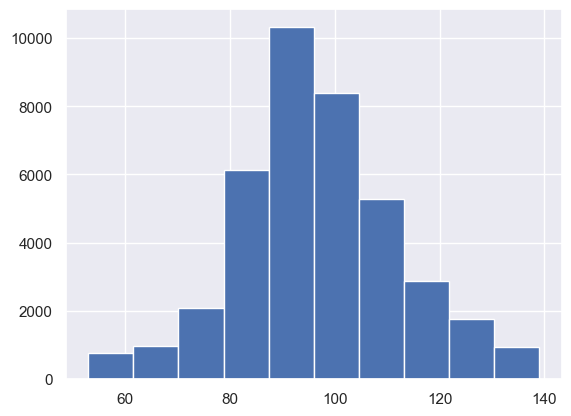

In [6]:
runtime = numeric_df.runtime
lower, upper, cantidad = outliers(runtime, method='iqr')
print('numero de outliers para "runtime" segun el metodo iqr:', cantidad)
# observamos que runtime, entre el lower y el upper limit, es normal
runtime[(runtime > lower) & (runtime < upper)].hist() 

In [7]:
# parece razonable imputar los valores faltantes por la media para los valores entre estos limites

average = runtime[(runtime > lower) & (runtime < upper)].mean()
numeric_df.runtime = numeric_df.runtime.fillna(average)

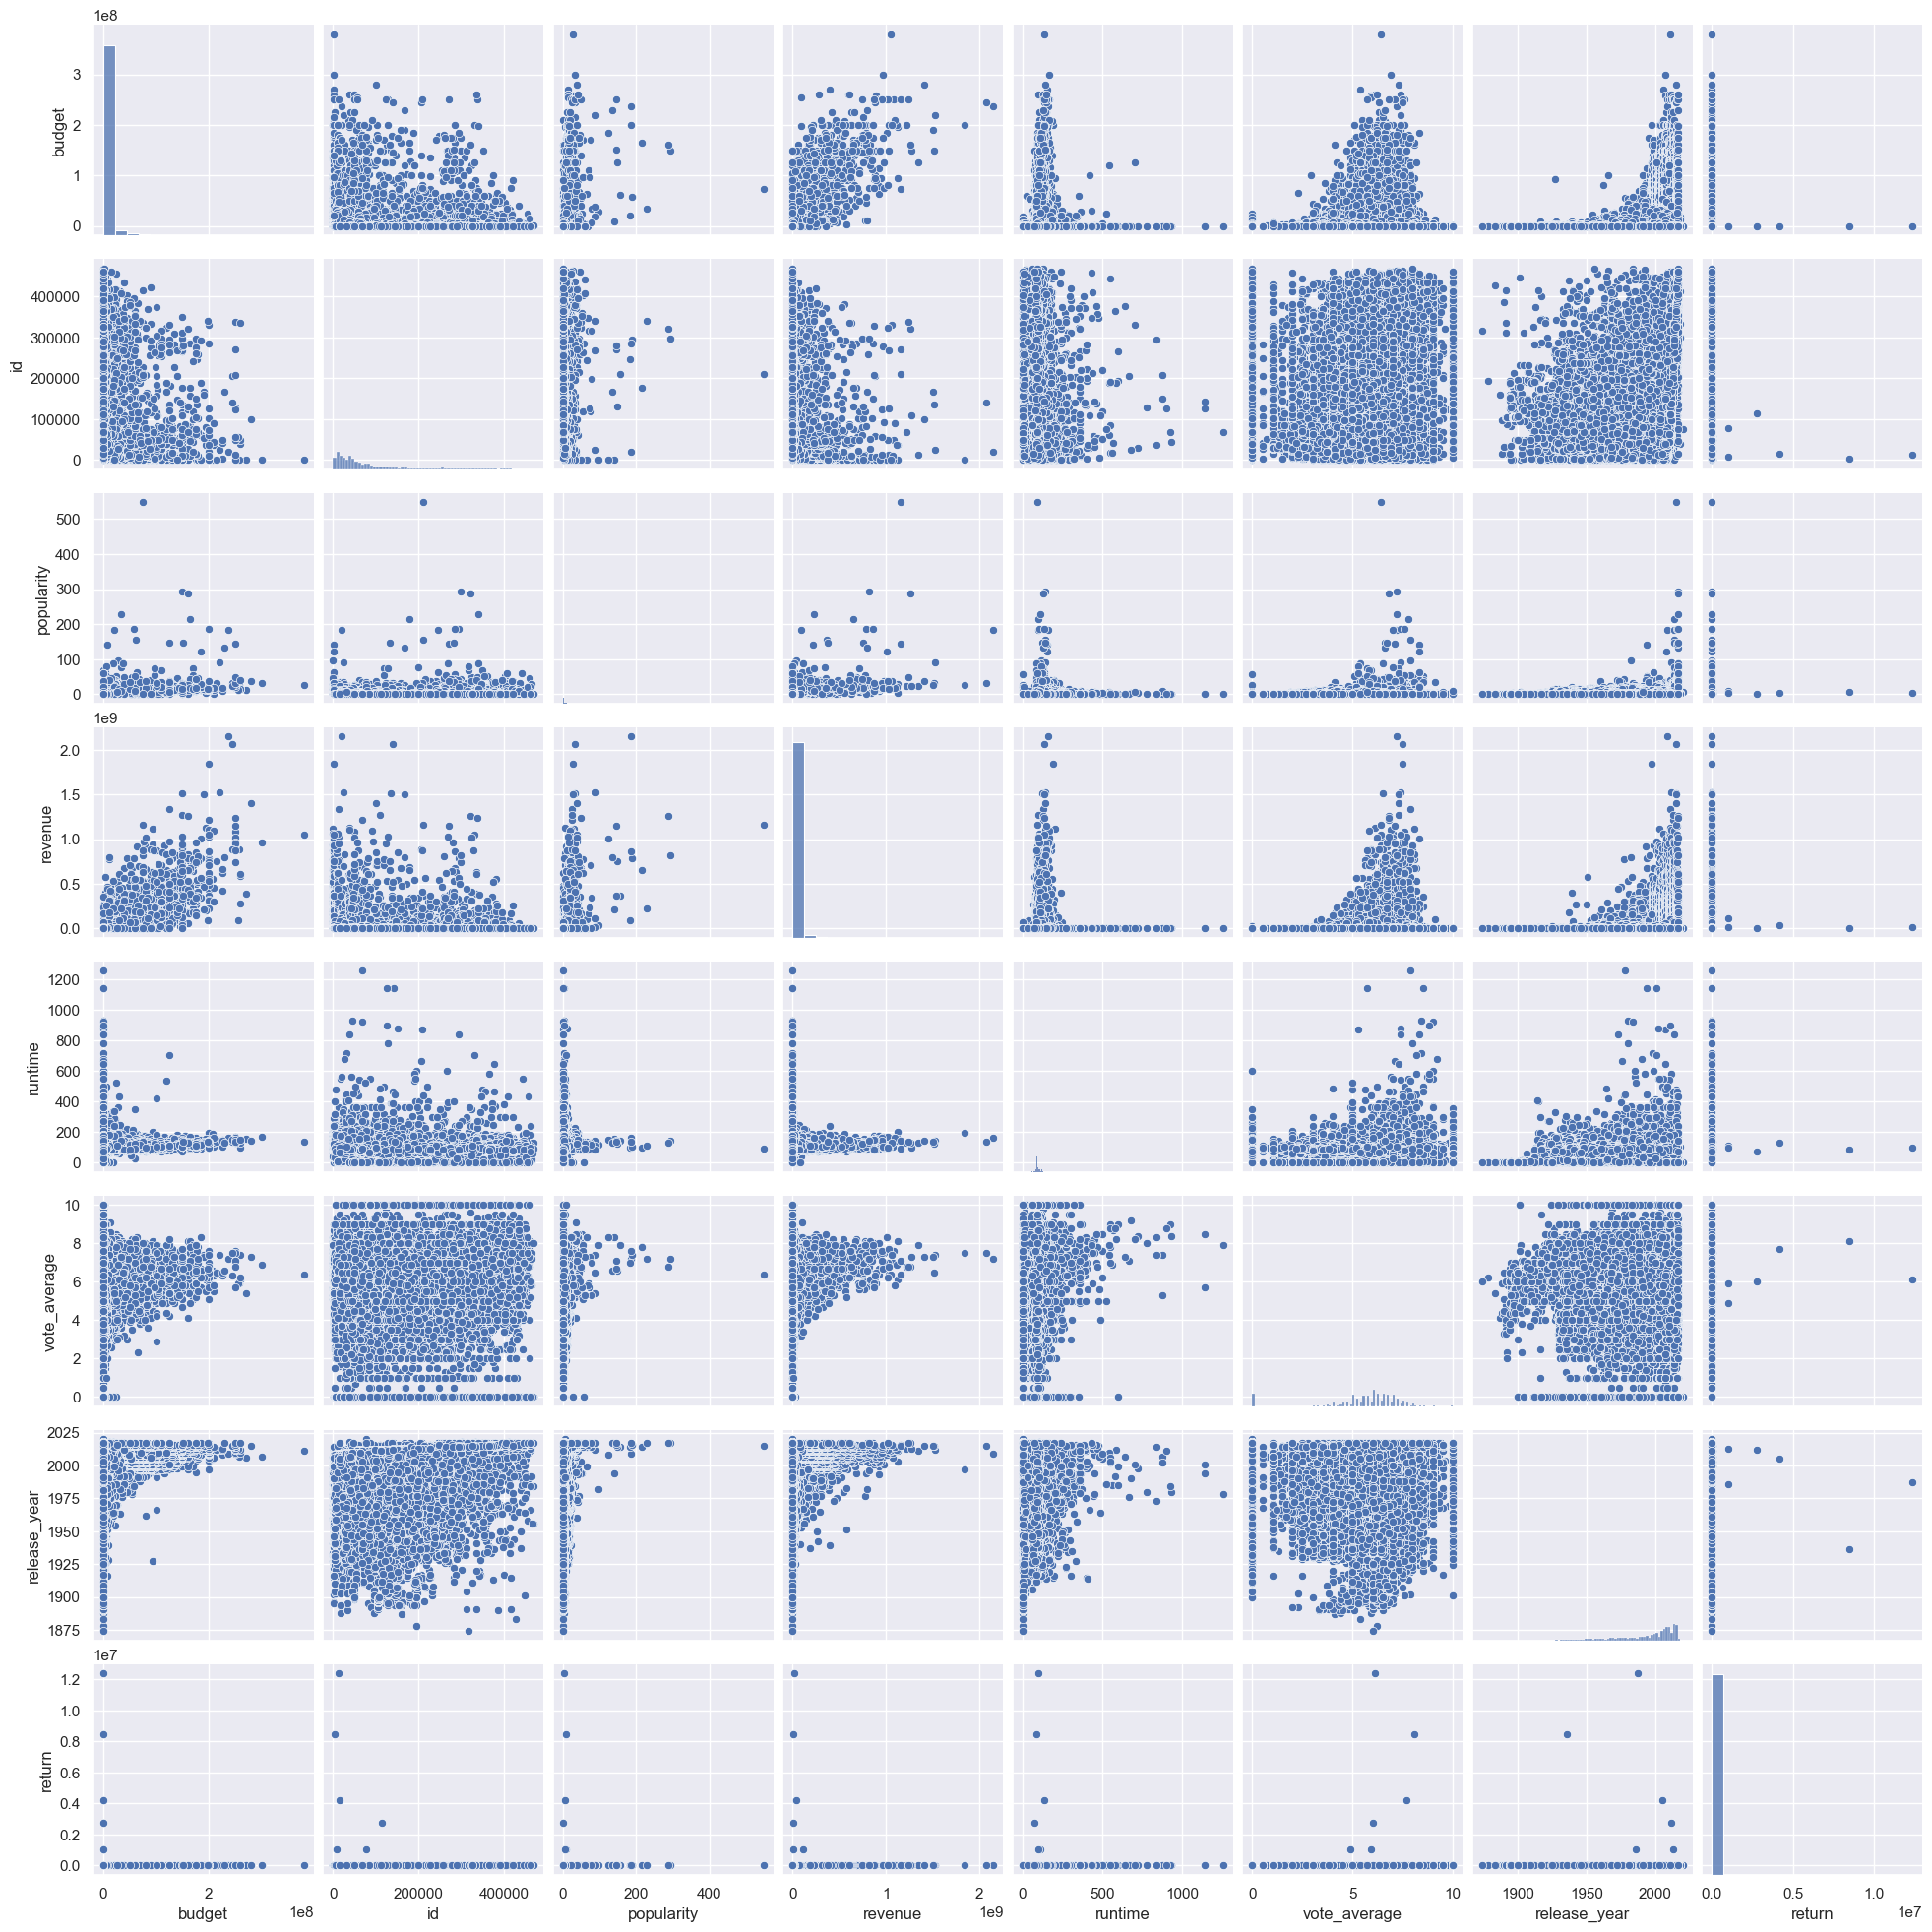

In [8]:
sns.pairplot(numeric_df)

<Axes: >

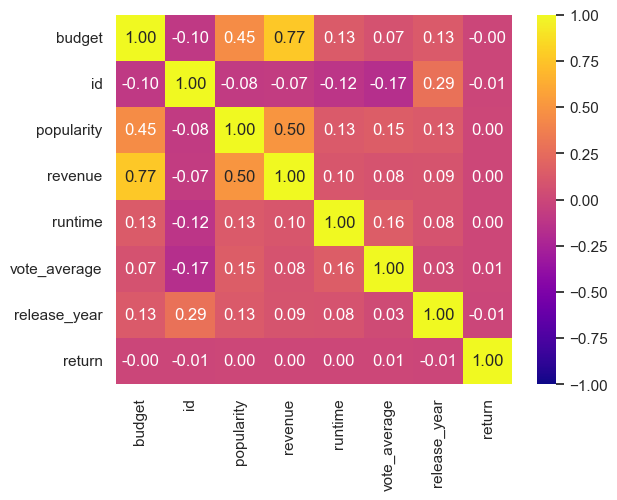

In [9]:
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='plasma')

In [10]:
numeric_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,release_year,return
count,4.529500e+04,45295.000000,45295.000000,4.529500e+04,45295.000000,45295.000000,45295.000000,4.529500e+04
mean,4.237033e+06,107963.875152,2.927578,1.123216e+07,94.188712,5.624276,1991.868352,6.612228e+02
std,1.745298e+07,112152.488467,6.013787,6.390377e+07,38.253979,1.915594,24.056790,7.476005e+04
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,1874.000000,0.000000e+00
25%,0.000000e+00,26378.500000,0.388764,0.000000e+00,85.000000,5.000000,1978.000000,0.000000e+00
50%,0.000000e+00,59744.000000,1.130942,0.000000e+00,95.000000,6.000000,2001.000000,0.000000e+00
75%,0.000000e+00,156327.500000,3.693627,0.000000e+00,107.000000,6.800000,2010.000000,0.000000e+00
max,3.800000e+08,469172.000000,547.488298,2.147484e+09,1256.000000,10.000000,2020.000000,1.239638e+07


In [11]:
for c in numeric_df.columns:
    lower, upper, cantidad = outliers(numeric_df[c], method='iqr')
    print(f'Cant. de outliers para "{c}": {cantidad}')

Cant. de outliers para "budget": 8869
Cant. de outliers para "id": 2486
Cant. de outliers para "popularity": 4203
Cant. de outliers para "revenue": 7397
Cant. de outliers para "runtime": 5380
Cant. de outliers para "vote_average": 3538
Cant. de outliers para "release_year": 774
Cant. de outliers para "return": 5375


El pairplot, los mapas de calor, y la tabla, nos ayuda a observar relaciones entre las variables, distribuciones, y rango de valores. 

Observamos:

1. Budget y Revenue estan correlacionados, y naturalmente Return tambien. Por lo que no lo usaremos ambos a la vez en el modelo.
2. Cada columna tiene distribuciones y rango de valores distintos, por lo que es menester estandarizar los valores.
3. Runtime incluye valores tambien para series, por lo que el valor maximo de 1256 tiene sentido. Este dataset deberia ser en principio solo de peliculas, sin embargo tiene ciertos errores que no perjudican al modelo, como se vera mas adelante.
4. La ventana temporal de nuestra peliculas va desde 1874 hasta 2020 esto nos permite crear una nueva columna que llamaremos "era"
5. Del mismo modo, realizamos lo propio con vote_average creando una columna llamada "ranking" que categoriza una pelicula segun su puntaje


In [12]:
# creamos la funcion para crear la columna era en object_columns
def create_era(year):
    if isinstance(year, int):
        if year < 1960:
            return 'clasicas'
        elif year < 2000:
            return 'retro'
        elif year < 2021:
            return 'contemporaneas'
    return ''

# creamos la funcion para crear la columna ranking en object_columns
def create_ranking(vote):
    if vote < 3: # si esta entre (0, 3)
        return 'mala'
    elif vote < 6: # si esta entre (3, 5)
        return 'regular'
    elif vote < 7.5: # si esta entre (5, 7.5)
        return 'buena'
    elif vote < 8.5: # si esta entre (7, 8.5)
        return 'muy buena'
    else: # si es mayor a 8.5
        return 'excelente'
    
# estos criterios son arbitrarios y se pueden probar otros si se quiere.

In [13]:
object_df['era'] = numeric_df.release_year.apply(create_era)

<Axes: ylabel='era'>

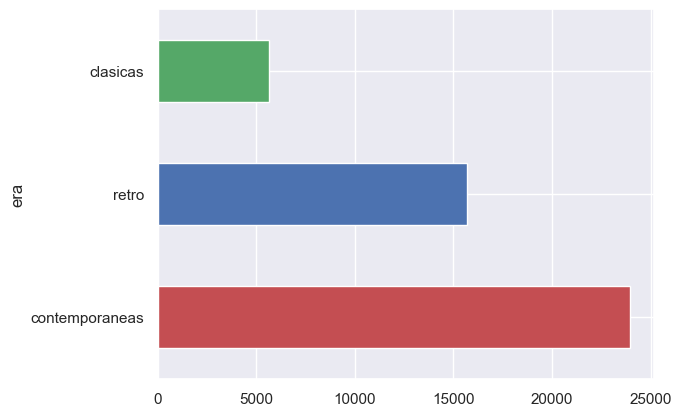

In [14]:
object_df['era'].value_counts().plot(kind='barh', color=['r', 'b', 'g'])

<Axes: >

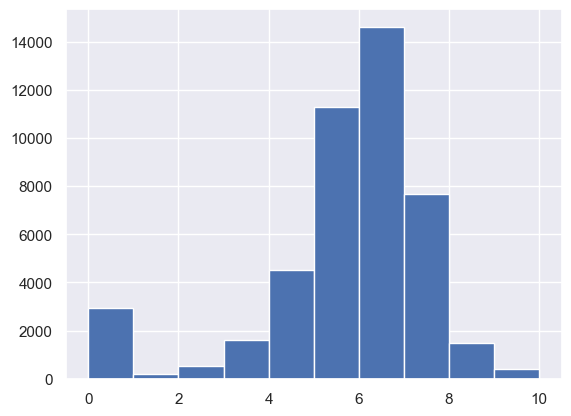

In [15]:
numeric_df.vote_average.hist() # observamos la distribucion de votos en el dataset, como vemos, la media es 7

In [16]:
object_df['ranking'] = numeric_df['vote_average'].apply(create_ranking)

<Axes: ylabel='ranking'>

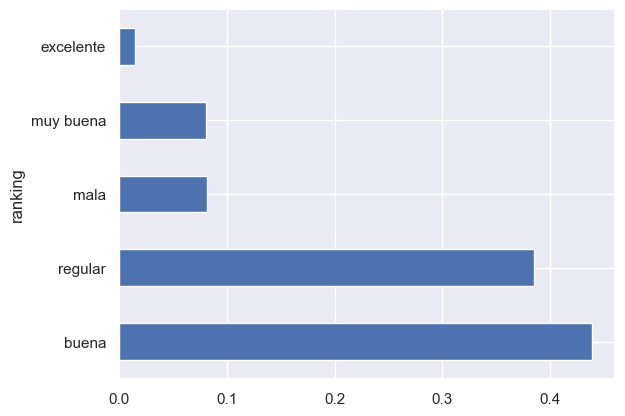

In [17]:
object_df['ranking'].value_counts(normalize=True).plot(kind='barh')

---

### OBJECT COLUMNS

In [18]:
# creamos el objecto nlp

nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words # stops words basado en "en_core_web_sm"

In [19]:
def limpiar_strings(inlist):
    outlist = []
    for string in inlist:
        # dada una string eliminamos cualquier caracter segun el regex
        x = re.sub(r'[^a-zA-Z0-9\s]', '', string)
        x = ' '.join(x.split())
        outlist.append(x)
    return outlist

def get_keyword(text):
    '''retorna una lista con palabras claves de "text"'''
    if not isinstance(text, str):
        return np.nan
    
    global nlp, stopwords
    doc = nlp(text)
    
    output = []
    for token in doc.noun_chunks:
        words = token.lemma_.lower().split(' ')
        string = []
        for word in words:
            # eliminamos del token todos los stopwords
            if word in stopwords:
                continue
            string.append(word)
        if len(string) >= 2: # nos quedamos con los "tokens" con mas de 2 palabras
            output.append(' '.join(string))
            
    return limpiar_strings(output)
    

In [27]:
start = time.time()
object_df['overview_keywords'] = object_df.overview.apply(get_keyword)
end = time.time()
print(f'tomo {end-start:.2f}s')

tomo 358.72s


In [25]:
object_df['overview_keywords'][0]

['andys toy', 'andys birthday', 'buzz lightyear', 'andys heart']

In [28]:
object_df.columns

Index(['original_language', 'overview', 'release_date', 'status', 'tagline',
       'title', 'belongs_to_collection', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'production_countries_iso',
       'spoken_languages_iso', 'release_month', 'release_day', 'era',
       'ranking', 'overview_keywords'],
      dtype='object')

In [29]:
columnas_lista = ['belongs_to_collection', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'production_countries_iso',
       'spoken_languages_iso']

for c in columnas_lista:
    object_df[c] = object_df[c].apply(ast.literal_eval)

In [30]:
def count_list(column):
    """Funciona como un value_counts pero para los casos en que los campos son listas
       devuelve un diccionario con el valor como key, y la frecuencia como value"""
    output = {}
    for v in column:
        for item in v:
            if item not in output:
                output[item] = 1
            else:
                output[item] += 1
    return output

In [31]:
lang = count_list(object_df.spoken_languages)
lang.keys()

dict_keys(['english', 'français', 'español', 'deutsch', 'pусский', 'latin', 'nederlands', '广州话 / 廣州話', '普通话', 'magyar', 'shqip', 'italiano', '한국어/조선말', 'فارسی', 'dansk', '', '日本語', 'العربية', 'hrvatski', 'bosanski', 'română', 'bahasa indonesia', 'bahasa melayu', 'svenska', 'עִבְרִית', 'český', 'polski', 'gaeilge', 'norsk', 'slovenčina', 'tiếng việt', 'português', 'हिन्दी', 'català', 'íslenska', 'afrikaans', 'srpski', 'বাংলা', 'wolof', 'cymraeg', 'ภาษาไทย', 'latviešu', 'kiswahili', 'български език', 'ελληνικά', 'türkçe', 'suomi', 'esperanto', 'український', 'ქართული', 'bokmål', 'no language', 'euskera', 'azərbaycan', 'malti', 'اردو', 'isizulu', 'bamanankan', 'پښتو', 'somali', 'ਪੰਜਾਬੀ', 'беларуская мова', 'தமிழ்', 'galego', 'kinyarwanda', 'қазақ', 'eesti', 'lietuvi\x9akai', 'slovenščina', 'తెలుగు', 'fulfulde', '??????', '?????', 'ozbek', 'hausa'])

In [32]:
lang_iso = count_list(object_df.spoken_languages_iso)
lang_iso.keys()

dict_keys(['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'])

In [33]:
 # estos se incluyen ADEMAS del vacio []. Dichos valores son incorrectos, abajo los corregimos.

lang_no_exists = ['', 'no language', '??????', '?????']
lang_iso_no_exists = ['xx']

In [34]:
def corregir(column, eliminar):
    """la funcion devuelve una lista con los valores corregidos de column
       chequea si un item se encuentra en la lista eliminar, si es asi lo remueve"""
    output = []
    for v in column:
        nueva = []
        for item in v:
            if item in eliminar:
                continue
            nueva.append(item)
        output.append(nueva)
    return output

def count_empty(columna):
    count = 0
    for v in columna:
        if len(v) == 0:
            count = count + 1
    return count

In [35]:
object_df['spoken_languages'] = corregir(object_df.spoken_languages, lang_no_exists)

In [36]:
object_df['spoken_languages_iso'] = corregir(object_df.spoken_languages_iso, lang_iso_no_exists)

In [37]:
print('numero de lista vacias para spoken_lang:', count_empty(object_df.spoken_languages))
print('numero de lista vacias para spoken_lang_iso:', count_empty(object_df.spoken_languages_iso))

numero de lista vacias para spoken_lang: 4194
numero de lista vacias para spoken_lang_iso: 4063


In [38]:
# observamos que para la columna genres, esta todo correcto
print('numero de lista vacias:', count_empty(object_df.genres))
count_list(object_df.genres).keys()

numero de lista vacias: 2382


dict_keys(['animation', 'comedy', 'family', 'adventure', 'fantasy', 'romance', 'drama', 'action', 'crime', 'thriller', 'horror', 'history', 'science fiction', 'mystery', 'war', 'foreign', 'music', 'documentary', 'western', 'tv movie'])

In [39]:
# En la columna production_countries existe soviet_union y east_germany que 'podrian' remplazarse por Rusia y Alemania

print('numero de lista vacias:', count_empty(object_df.production_countries))
# count_list(object_df.production_countries).keys()

numero de lista vacias: 6201


In [40]:
# Para la columna production_countries_iso parece corresponder cada iso con un pais.

print('numero de lista vacias:', count_empty(object_df.production_countries_iso))
# count_list(object_df.production_countries_iso).keys()

numero de lista vacias: 6201


In [41]:
# Para la columna belongs_to_collection pareciera estar correcto

print('numero de lista vacias:', count_empty(object_df.belongs_to_collection))
# count_list(object_df.belongs_to_collection).keys()

numero de lista vacias: 40812


Ahora, creamos DOC y VOCAB.

DOC: es una cadena o string formado por la union de tokens (strings con una o mas palabras) de cada columna de texto.

VOCAB: es un dataframe que contiene todos los unicos tokens de la columna DOC.

In [51]:
def create_doc_vocab(df, text_column=None):
    ''' crea la columna doc en df y devuelve vocab 
        la columna doc se crea segun las columnas en text_column '''
    
    if not text_column:
        text_column = df.select_dtypes(exclude=np.number).drop(columns=['title']).columns.tolist()

    df['doc'] = ''
    vocab = []
    soup = []

    # este codigo recorre cada fila, para cada fila hace uso de todas las columnas text_column
    # si una palabra en una columna "C" no se encuentra en vocab, lo agrega.
    # soup es una lista de tokens asociada a cada pelicula/fila
    for i, row in df.iterrows():
        for c in text_column:
            if isinstance(row[c], list):
                for token in row[c]:
                    if token not in vocab:
                        vocab.append(token)
                    soup.append(token)
            elif isinstance(row[c], str):
                if row[c] not in vocab:
                    vocab.append(row[c])
                soup.append(row[c])
        df.loc[i, 'doc'] = ' '.join(soup)
        soup = []
    return vocab

In [46]:
object_df.columns

Index(['original_language', 'overview', 'release_date', 'status', 'tagline',
       'title', 'belongs_to_collection', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'production_countries_iso',
       'spoken_languages_iso', 'release_month', 'release_day', 'era',
       'ranking', 'overview_keywords'],
      dtype='object')

In [49]:
# estas son las columnas de TEXTO que usaremos para construir una "sopa" de palabras con la que calcular la similitud

# notemos que incluimos era, ranking, y overview_keywords
columns_for_doc = ['belongs_to_collection', 'genres', 'production_companies', 
                    'production_countries_iso', 'spoken_languages_iso', 'era', 'ranking', 'overview_keywords']

In [54]:
start = time.time()
vocab = create_doc_vocab(object_df, columns_for_doc)
end = time.time()
print(f'tomo {end-start:.2f}s')

tomo 499.39s


In [55]:
print('Numero de tokens:', len(vocab))
print('Ejemplo de 10 TOKENS en VOCAB:')
vocab[:10]

Numero de tokens: 209237
Ejemplo de 10 TOKENS en VOCAB:


['toy story collection',
 'animation',
 'comedy',
 'family',
 'pixar animation studios',
 'us',
 'en',
 'retro',
 'muy buena',
 'andys toy']

In [57]:
print('Ejemplo del SOUP de tokens asociado a cada MOVIE:')
object_df[['title', 'doc']].head(5)

Ejemplo del SOUP de tokens asociado a cada MOVIE:


,title,doc
0,toy story,toy story collection animation comedy family p...
1,jumanji,adventure fantasy family tristar pictures teit...
2,grumpier old men,grumpy old men collection romance comedy warne...
3,waiting to exhale,comedy drama romance twentieth century fox fil...
4,father of the bride part ii,father of the bride collection comedy sandolla...


### UNION

In [63]:
output = pd.concat([object_df, numeric_df], axis=1)
output.to_csv('../data/movies_etlv2.csv', sep=',', header=True, index=False)
pd.DataFrame({'vocab':vocab}).to_csv('../data/vocab.csv', sep=',', header=True, index=False)